In [1]:
from pipelines.data_preparation_pipeline import DataPreparationPipeline
from fake_news_classifier import FakeNewsClassifier
from utils.utils import load_config
import shap
import lime
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data_preparation_pipeline = DataPreparationPipeline(
    "configs/pipelines_config/data_preparation_config.json"
)
train_data, test_data, val_data = data_preparation_pipeline.run()

fake_news_classifier = FakeNewsClassifier("configs/classifier_config.json", 7)
model = fake_news_classifier.load_pretrained("models/best_model.pth")

#################### Data Preparation Pipeline  ####################
===== Loading data... =====
===== Applying label mapping... =====
===== Splitting data... =====
Data preparation pipeline completed.
##################################################


{'accuracy': 0.971296659262163, 'precision': 0.9713146285670903, 'recall': 0.971296659262163, 'f1_score': 0.9713005984735034}
Model loaded successfully from models/best_model.pth


In [3]:
config = load_config("configs/pipelines_config/explainability_config.json")
num_explain_samples = config["num_explain_samples"]

contents = val_data["content"].to_list()
labels = val_data["label"].to_list()
tokenizer = model.tokenizer

In [4]:
def run_shap(model):
    print("Starting SHAP explainability analysis...")
    label_map = {
        0: "reliable",
        1: "bias",
        2: "conspiracy",
        3: "fake",
        4: "rumor",
        5: "unreliable",
        6: "other",
    }
    class_contents = {i: [] for i in range(len(label_map))}
    for content, label in zip(contents, labels):
        class_contents[label].append(content)
    samples_per_class = max(1, num_explain_samples // len(label_map))
    sampled_contents = []
    for class_label, class_data in class_contents.items():
        if class_data:
            num_samples = min(samples_per_class, len(class_data))
            sampled_contents.extend(
                np.random.choice(class_data, size=num_samples, replace=False)
            )
    masker = shap.maskers.Text(tokenizer)
    output_names = [label_map[i] for i in range(len(label_map))]
    explainer = shap.Explainer(model.predict_proba, masker, output_names=output_names)
    shap_values = explainer(sampled_contents)
    print("SHAP values computed successfully.")
    return shap_values

In [ ]:
shap_values = run_shap(model=model)

Starting SHAP explainability analysis...


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   0%|          | 1/1400 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   0%|          | 3/1400 [00:46<4:14:13, 10.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   0%|          | 4/1400 [01:08<6:10:26, 15.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   0%|          | 5/1400 [01:32<7:12:58, 18.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   0%|          | 6/1400 [01:55<7:48:52, 20.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   0%|          | 7/1400 [02:18<8:08:57, 21.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 8/1400 [02:40<8:17:45, 21.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 9/1400 [03:03<8:30:15, 22.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 10/1400 [03:25<8:28:54, 21.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 11/1400 [03:47<8:31:10, 22.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 12/1400 [04:10<8:37:41, 22.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 13/1400 [04:33<8:41:18, 22.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 14/1400 [04:56<8:39:50, 22.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 15/1400 [05:18<8:36:27, 22.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 16/1400 [05:40<8:37:24, 22.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]


--- Top 50 tokens positively contributing to label: reliable ---
1.  game: 0.263502
2.  .: 0.237868
3. time: 0.225477
4. game: 0.057031
5.  ,: 0.056340
6.  ': 0.038908
7.  back: 0.035096
8.  performance: 0.031074
9.  the: 0.025964
10.  ts: 0.022797

--- Top 50 tokens positively contributing to label: bias ---
1.  unknown: 0.993372
2.  post: 0.493570
3.  ,: 0.250759
4.  ®: 0.232793
5.  the: 0.083743
6.  patriot: 0.065713
7.  :: 0.049647
8.  (: 0.046069
9.  -: 0.026649
10.  .: 0.019504

--- Top 50 tokens positively contributing to label: conspiracy ---
1.  property: 0.568598
2.  ": 0.132595
3.  |: 0.096478
4.  unknown: 0.047681
5.  :: 0.037226
6.  50: 0.036531
7.  value: 0.035101
8.  whitehead: 0.021805
9.  have: 0.017192
10.  has: 0.015729

--- Top 50 tokens positively contributing to label: fake ---
1.  .: 0.124652
2.  s: 0.112831
3.  news: 0.094333
4.  ): 0.093210
5.  it: 0.093181
6.  ': 0.093072
7.  a: 0.052720
8.  game: 0.049411
9.  the: 0.036186
10.  (: 0.030997

--- Top 50 tokens

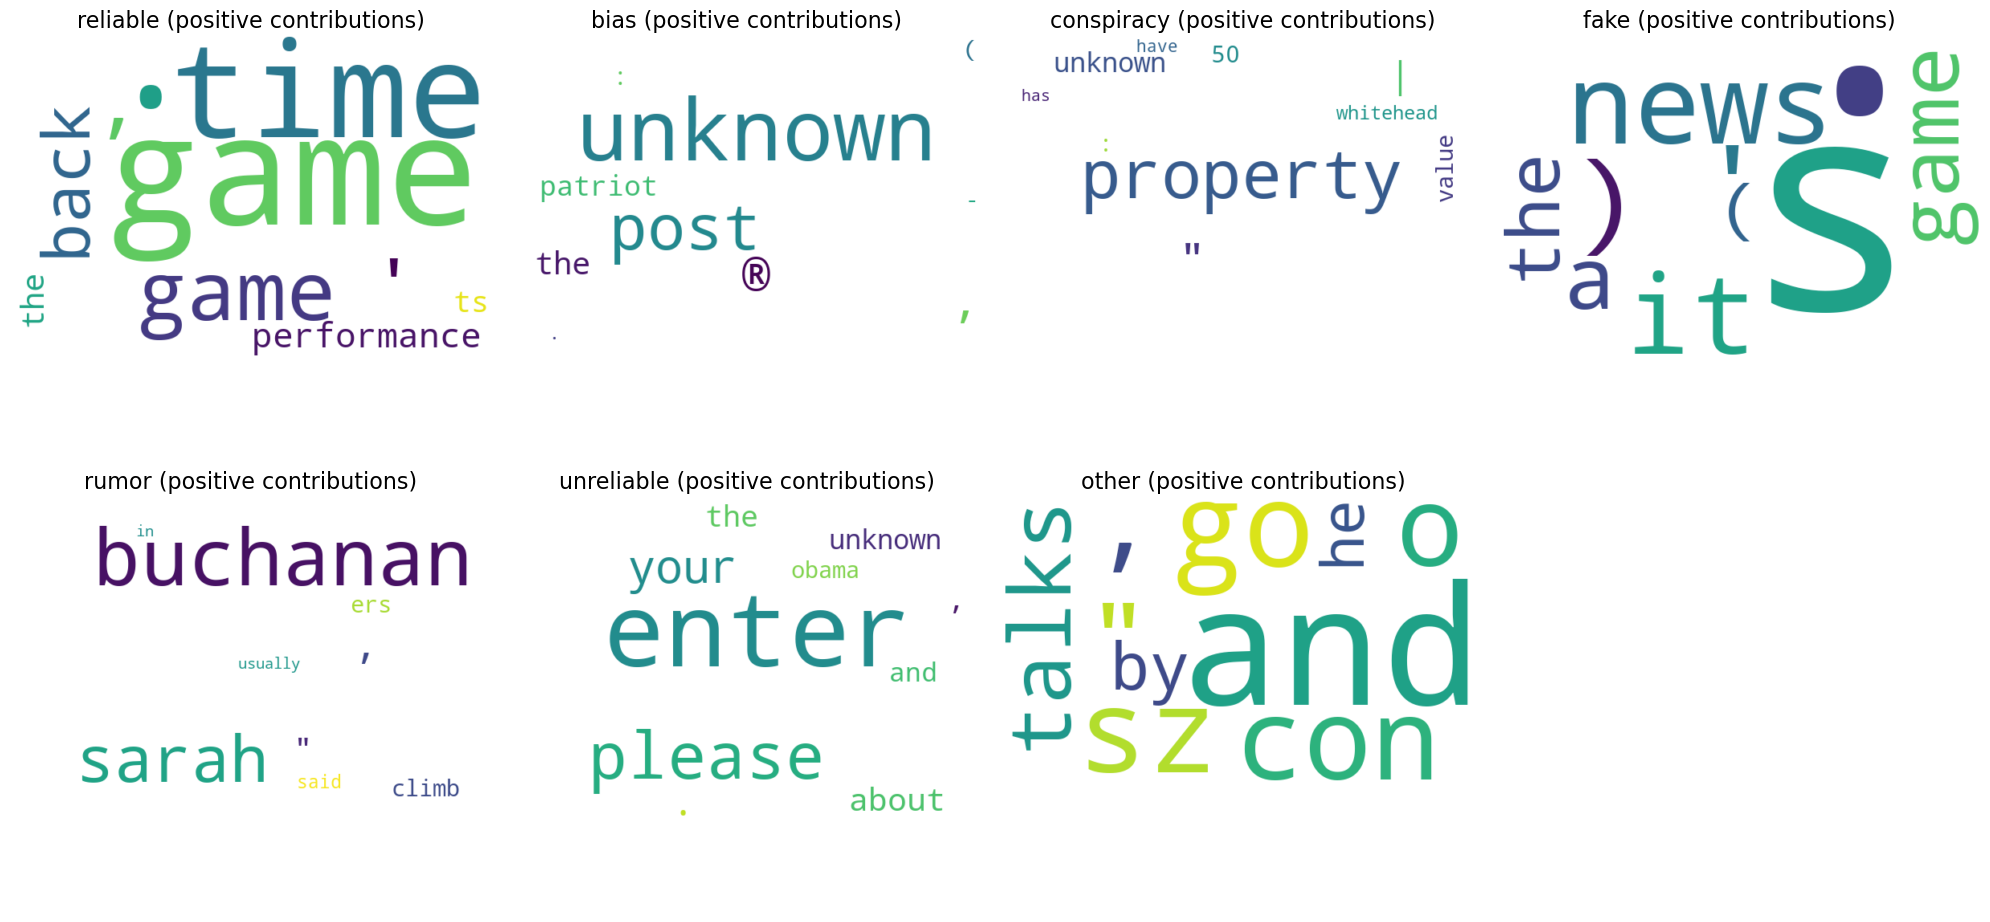

In [ ]:
# === Aggregate positive token contributions per class ===
token_contributions = defaultdict(
    lambda: defaultdict(float)
)  # token_contributions[token][class_label]

# Token to ignore
IGNORE_TOKEN = " [SEP]"

for sv in shap_values:
    tokens = sv.data
    values = sv.values  # shape: (num_tokens, num_classes)
    for token_idx, token in enumerate(tokens):
        # Skip the [SEP] token
        if token == IGNORE_TOKEN:
            continue
        for class_idx, value in enumerate(values[token_idx]):
            # Only add positive contributions
            if value > 0:
                token_contributions[token][
                    class_idx
                ] += value  # Only accumulate positive values

# === Prepare label names ===
label_map = {
    0: "reliable",
    1: "bias",
    2: "conspiracy",
    3: "fake",
    4: "rumor",
    5: "unreliable",
    6: "other",
}

# === Print and create word clouds for top positive contributing tokens ===
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
for class_idx in range(len(label_map)):
    # Extract word importance scores
    token_scores = {
        token: contribs[class_idx] for token, contribs in token_contributions.items()
    }

    # Remove [SEP] token if it somehow made it into the scores
    if IGNORE_TOKEN in token_scores:
        del token_scores[IGNORE_TOKEN]

    # Sort tokens by contribution value
    sorted_items = sorted(token_scores.items(), key=lambda x: x[1], reverse=True)
    sorted_tokens = dict(sorted_items[:20])  # top 50 for word cloud

    # Print the top 50 positive contributing tokens for this class
    print(
        f"\n--- Top 50 tokens positively contributing to label: {label_map[class_idx]} ---"
    )
    for i, (token, score) in enumerate(sorted_items[:10], 1):
        print(f"{i}. {token}: {score:.6f}")

    # Generate word cloud
    wc = WordCloud(
        width=600, height=400, background_color="white"
    ).generate_from_frequencies(sorted_tokens)
    axs[class_idx].imshow(wc, interpolation="bilinear")
    axs[class_idx].axis("off")
    axs[class_idx].set_title(
        f"{label_map[class_idx]} (positive contributions)", fontsize=16
    )

# Hide extra subplot if fewer than 8 classes
for i in range(len(label_map), len(axs)):
    axs[i].axis("off")

plt.tight_layout()
plt.show()